# Debug

In [1]:
from functools import partial
from qiskit.quantum_info import SparsePauliOp, random_statevector

import scipy.sparse.linalg as ssla
from scipy import sparse
import pandas as pd
import scipy
import jax

import matplotlib.pyplot as plt
import numpy as np

from utils import *
# from lightcone import *
from spin_ham import *
from trotter import *
from bounds import *
# from noise import *

figs_dir, data_dir = './figs', './data'

In [ ]:
# demo of the nearest-neighbor Hamiltonian
hnn = Nearest_Neighbour_1d(3, Jx=2, Jy=2, Jz=2, hx=0, hy=0, hz=1, pbc=False, verbose=True)
n = 8
r = 100
J, h = 1, 0.2
t_list = np.linspace(1, 10, 20)

hnn = Nearest_Neighbour_1d(n, Jx=J, Jy=J, Jz=J, hx=0, hy=0, hz=h, pbc=False, verbose=False)
singl_ob = SparsePauliOp.from_sparse_list([('Z', [0], 1)], n).to_matrix()
multi_ob = SparsePauliOp.from_sparse_list([(random.choice(['X','Y','Z']), [i], 1) for i in range(0, n)], n).to_matrix()
multi_ob = multi_ob / np.linalg.norm(multi_ob, ord=2)
# multi_ob = SparsePauliOp.from_sparse_list([('Z', [i], 1/n) for i in range(0, n)], n).to_matrix()
h_list = [h.to_matrix(True) for h in hnn.ham_par]
for t in t_list:
    exact_U = scipy.linalg.expm(-1j * t * sum([h.to_matrix() for h in hnn.ham_par]))
    appro_U = pf_r(h_list, t, r, order=2)
    exact_ob_s = exact_U.conj().T @ singl_ob @ exact_U 
    appro_ob_s = appro_U.conj().T @ singl_ob @ appro_U
    exact_ob_m = exact_U.conj().T @ multi_ob @ exact_U 
    appro_ob_m = appro_U.conj().T @ multi_ob @ appro_U
    ob_error_s = np.linalg.norm(exact_ob_s - appro_ob_s, ord=2)
    ob_error_m = np.linalg.norm(exact_ob_m - appro_ob_m, ord=2)
    print('single ob error (operator norm): ', ob_error_s)
    print('multip ob error (operator norm): ', ob_error_m)

In [2]:
from spin_ham import *
from qiskit.quantum_info import SparsePauliOp
import scipy, numpy
from trotter import *
import sys

n = 9
r = 1
t = 0.5
J, h = 1, 0.2
hnn = Nearest_Neighbour_1d(n, Jx=0, Jy=0, Jz=J, hx=h, hy=0, hz=0, pbc=False, verbose=False)
ob = SparsePauliOp.from_sparse_list([('Z', [0], 1)], n).to_matrix()
exact_U = scipy.linalg.expm(-1j * t * sum([h.to_matrix() for h in hnn.ham_par]))
h_list = [h.to_matrix(True) for h in hnn.ham_par]
appro_U = pf_r(h_list, t, r, order=2)
exact_ob_s = exact_U.conj().T @ ob @ exact_U 
appro_ob_s = appro_U.conj().T @ ob @ appro_U
scipy.linalg.norm(exact_ob_s - appro_ob_s, ord=2)  
print(np.linalg.norm(exact_ob_s))
print(np.linalg.norm(appro_ob_s, ord=2))
print(np.linalg.norm(exact_ob_s - appro_ob_s, ord='nuc'))
print(np.trace(exact_ob_s - appro_ob_s))
print(np.linalg.norm(exact_ob_s - appro_ob_s, ord=2))
# np.linalg.eigvals(exact_ob_s - appro_ob_s)
print(np.sort(abs(np.linalg.eigvalsh(exact_ob_s - appro_ob_s)))[-1])
# exact_ob_m = exact_U.conj().T @ multi_ob @ exact_U 
# appro_ob_m = appro_U.conj().T @ multi_ob @ appro_U
file_path = 'matrix6.txt'
# Save the matrix to the file
np.savetxt(file_path, exact_ob_s - appro_ob_s, delimiter=',')
# sys.modules[__name__].__dict__.clear()
# globals().clear()
# %reset

22.627416997969508
1.0000000000000169
1.4649881645461555
(-9.015010959956271e-14+4.255092054469643e-18j)
0.0028613051827964587
0.002861305182796463


In [38]:
# from spin_ham import *
# from trotter import *
# import sys
from qiskit.quantum_info import SparsePauliOp
import scipy
import numpy as np
import jax

t = 0.5
J, h = 1, 0.2
for n in [7, 8, 9, 10]:
# for n in [7, 8, 9, 10, 11]:
    # r = 1
    # hnn = Nearest_Neighbour_1d(n, Jx=0, Jy=0, Jz=J, hx=h, hy=0, hz=0, pbc=False, verbose=False)
    zz_tuples = [('ZZ', [i, i + 1], J) for i in range(0, n-1)]
    x_tuples = [('X', [i], h) for i in range(0, n)] 
    ham = SparsePauliOp.from_sparse_list([*zz_tuples, *x_tuples], n).simplify() 
    even_terms = SparsePauliOp.from_sparse_list([*zz_tuples[::2], *x_tuples[::2]], n).simplify()
    odd_terms = SparsePauliOp.from_sparse_list([*zz_tuples[1::2], *x_tuples[1::2]], n).simplify()
    ham_par = [even_terms, odd_terms]
    ob = SparsePauliOp.from_sparse_list([('Z', [0], 1)], n).to_matrix()
    # print('ob: ', ob)
    # exact_U = scipy.linalg.expm(-1j * t * sum([h.to_matrix() for h in hnn.ham_par]))
    h_list = [h.to_matrix() for h in ham_par]
    exact_U = np.matrix(jax.scipy.linalg.expm(-1j * t * sum([h for h in h_list])))
    print('n = ', n, h_list[0].shape)
    # for r in [1]:
    for r in [1, 2]:
        list_U = [jax.scipy.linalg.expm(-1j * (t / (2*r)) * h) for h in h_list]
        # list_U = [scipy.linalg.expm(-1j * (t / (2*r)) * h) for h in h_list]
        # if verbose: print('----expm Herm finished----')
        # appro_U_dt_forward = np.linalg.multi_dot(list_U)
        # appro_U_dt_reverse = np.linalg.multi_dot(list_U[::-1])
        appro_U_dt_forward = np.matmul(list_U[0], list_U[1])
        appro_U_dt_reverse = np.matmul(list_U[1], list_U[0])
        # appro_U_dt_forward = list_U[0] @ list_U[1]
        # appro_U_dt_reverse = list_U[1] @ list_U[0]
        # appro_U_dt = list_U[0] @ list_U[1]
        # if verbose: print('----matrix product finished----')
        # appro_U = np.matrix(appro_U_dt_reverse @ appro_U_dt_forward)
        appro_U = np.matrix(np.linalg.matrix_power(np.matmul(appro_U_dt_reverse, appro_U_dt_forward), r))
        # appro_U = np.matrix(np.linalg.matrix_power(appro_U_dt_reverse @ appro_U_dt_forward, r))
        # appro_U = np.matrix(pf_r(h_list, t, r, order=2))
        exact_ob = np.matmul(exact_U.H, np.matmul(ob, exact_U))
        appro_ob = np.matmul(appro_U.H, np.matmul(ob, appro_U))
        # exact_ob = exact_U.H @ ob @ exact_U 
        # appro_ob = appro_U.H @ ob @ appro_U
        np.allclose(exact_ob, exact_ob.conj().T)
        np.allclose(appro_ob, appro_ob.conj().T)
        # np.save(f'./data/exact_ob_{n}_{r}.npy', appro_U)

        # appro_ob_s = appro_U.conj().T @ ob @ appro_U
        # scipy.linalg.norm(exact_ob_s - appro_ob_s, ord=2)  
        # print(np.linalg.norm(exact_ob_s))
        # print(np.linalg.norm(appro_ob_s, ord=2))
        # print(np.linalg.norm(exact_ob_s - appro_ob_s, ord='nuc'))
        # print(np.trace(exact_ob_s - appro_ob_s))
        # print(np.linalg.norm(exact_ob - appro_ob, ord=2))
        err_op = exact_ob - appro_ob
        # np.linalg.eigvals(exact_ob_s - appro_ob_s)
        print(np.sort(abs(np.linalg.eigvalsh(err_op)))[-1])
        # print(exact_ob[0,0], err_op[0,0], appro_ob[0,0])

n =  7 (128, 128)
0.00286220803327422
0.0006709485731051255
n =  8 (256, 256)
0.0028623574552221406
0.0006716175211252401
n =  9 (512, 512)
0.0028626517531851192
0.0006725913518191965
n =  10 (1024, 1024)
0.002862755945093186
0.0006719952371922001


In [19]:
appro_U_18 = np.load(f'./data/exact_ob_9_1_18.npy')
appro_U_28 = np.load(f'./data/exact_ob_9_1_28.npy')
appro_U_85 = np.load(f'./data/exact_ob_9_1_85.npy')
appro_U_28 - appro_U_85

array([[ 1.10876450e-01+1.05853044e-01j,  1.30322901e-02-8.83995997e-04j,
         8.11128069e-03+2.21833848e-03j, ...,
         1.55045368e-09-1.72222480e-09j,  8.46805621e-10-1.83576306e-09j,
        -2.32676865e-10-1.14028224e-10j],
       [ 1.30322901e-02-8.83995981e-04j, -1.98717539e-02+1.14135515e-01j,
         7.77389272e-04-9.10797202e-04j, ...,
         5.47176067e-09+2.00686959e-08j, -2.32774082e-10-1.14855037e-10j,
         8.43216883e-10-1.83767636e-09j],
       [ 8.11663865e-03+2.19660448e-03j,  7.77389000e-04-9.10797126e-04j,
        -7.27762262e-02+3.25817607e-02j, ...,
        -1.37201516e-10-2.19998177e-10j,  5.43707044e-09+2.00871026e-08j,
         1.55395401e-09-1.72018619e-09j],
       ...,
       [ 1.55395401e-09-1.72018619e-09j,  5.43707044e-09+2.00871026e-08j,
        -1.37201516e-10-2.19998177e-10j, ...,
        -7.27762262e-02+3.25817607e-02j,  7.77389000e-04-9.10797126e-04j,
         8.11663865e-03+2.19660448e-03j],
       [ 8.43216883e-10-1.83767636e-09j, -2.

(0.9816722463159797-2.332325238166409e-17j) (-0.0012541762468709639-2.181573997780833e-17j) (0.9829264225628507-1.5075124038557586e-18j)

(0.9816722463159797-2.332325238166409e-17j) (-2.1008833811508865e-06-4.2249428514288504e-17j) (0.9816743471993609+1.8926176132624414e-17j)

0.0171
(0.9816722463159797-2.332325238166409e-17j) (0.000914037141718782-1.882305977087255e-17j) (0.9807582091742609-4.500192610791541e-18j)

In [ ]:
exact_ob_s - appro_ob_s

array([[-1.254176e-03-2.181574e-17j,  6.357182e-03-4.164055e-03j,
         1.916763e-05-1.260949e-05j, ...,  1.138114e-13+1.771224e-14j,
         2.546533e-14-2.143273e-15j, -3.808590e-24-1.113026e-14j],
       [ 6.357182e-03+4.164055e-03j,  1.250334e-03-1.912847e-17j,
        -3.839087e-04+1.884769e-03j, ..., -4.872551e-14-2.846347e-13j,
         6.187315e-24+1.218178e-15j, -2.546533e-14-2.143273e-15j],
       [ 1.916763e-05+1.260949e-05j, -3.839087e-04-1.884769e-03j,
        -1.263336e-03+4.499314e-17j, ...,  4.909774e-24+1.084614e-14j,
         4.872551e-14-2.846347e-13j, -1.138114e-13+1.771224e-14j],
       ...,
       [ 1.138114e-13-1.771224e-14j, -4.872551e-14+2.846347e-13j,
         4.909774e-24-1.084614e-14j, ...,  1.263336e-03+6.588282e-18j,
         3.839087e-04+1.884769e-03j, -1.916763e-05-1.260949e-05j],
       [ 2.546533e-14+2.143273e-15j,  6.187315e-24-1.218178e-15j,
         4.872551e-14+2.846347e-13j, ...,  3.839087e-04-1.884769e-03j,
        -1.250334e-03-3.024805e-18j

## 1D Transverse Field Ising Chain
- Reduced product formula
- Chromatic product formula: multi-observable


### Different groupings

J=1, h=0.2, t=0.5, r=5
n=4, empirical error_xyz=0.000605, empirical error_parity=0.000389
n=5, empirical error_xyz=0.000646, empirical error_parity=0.000472
n=6, empirical error_xyz=0.000668, empirical error_parity=0.000452
n=7, empirical error_xyz=0.000687, empirical error_parity=0.000501
n=8, empirical error_xyz=0.000699, empirical error_parity=0.000483
n=9, empirical error_xyz=0.000710, empirical error_parity=0.000517
n=10, empirical error_xyz=0.000718, empirical error_parity=0.000501
n=11, empirical error_xyz=0.000724, empirical error_parity=0.000527
n=12, empirical error_xyz=0.000730, empirical error_parity=0.000513
n=13, empirical error_xyz=0.000734, empirical error_parity=0.000534


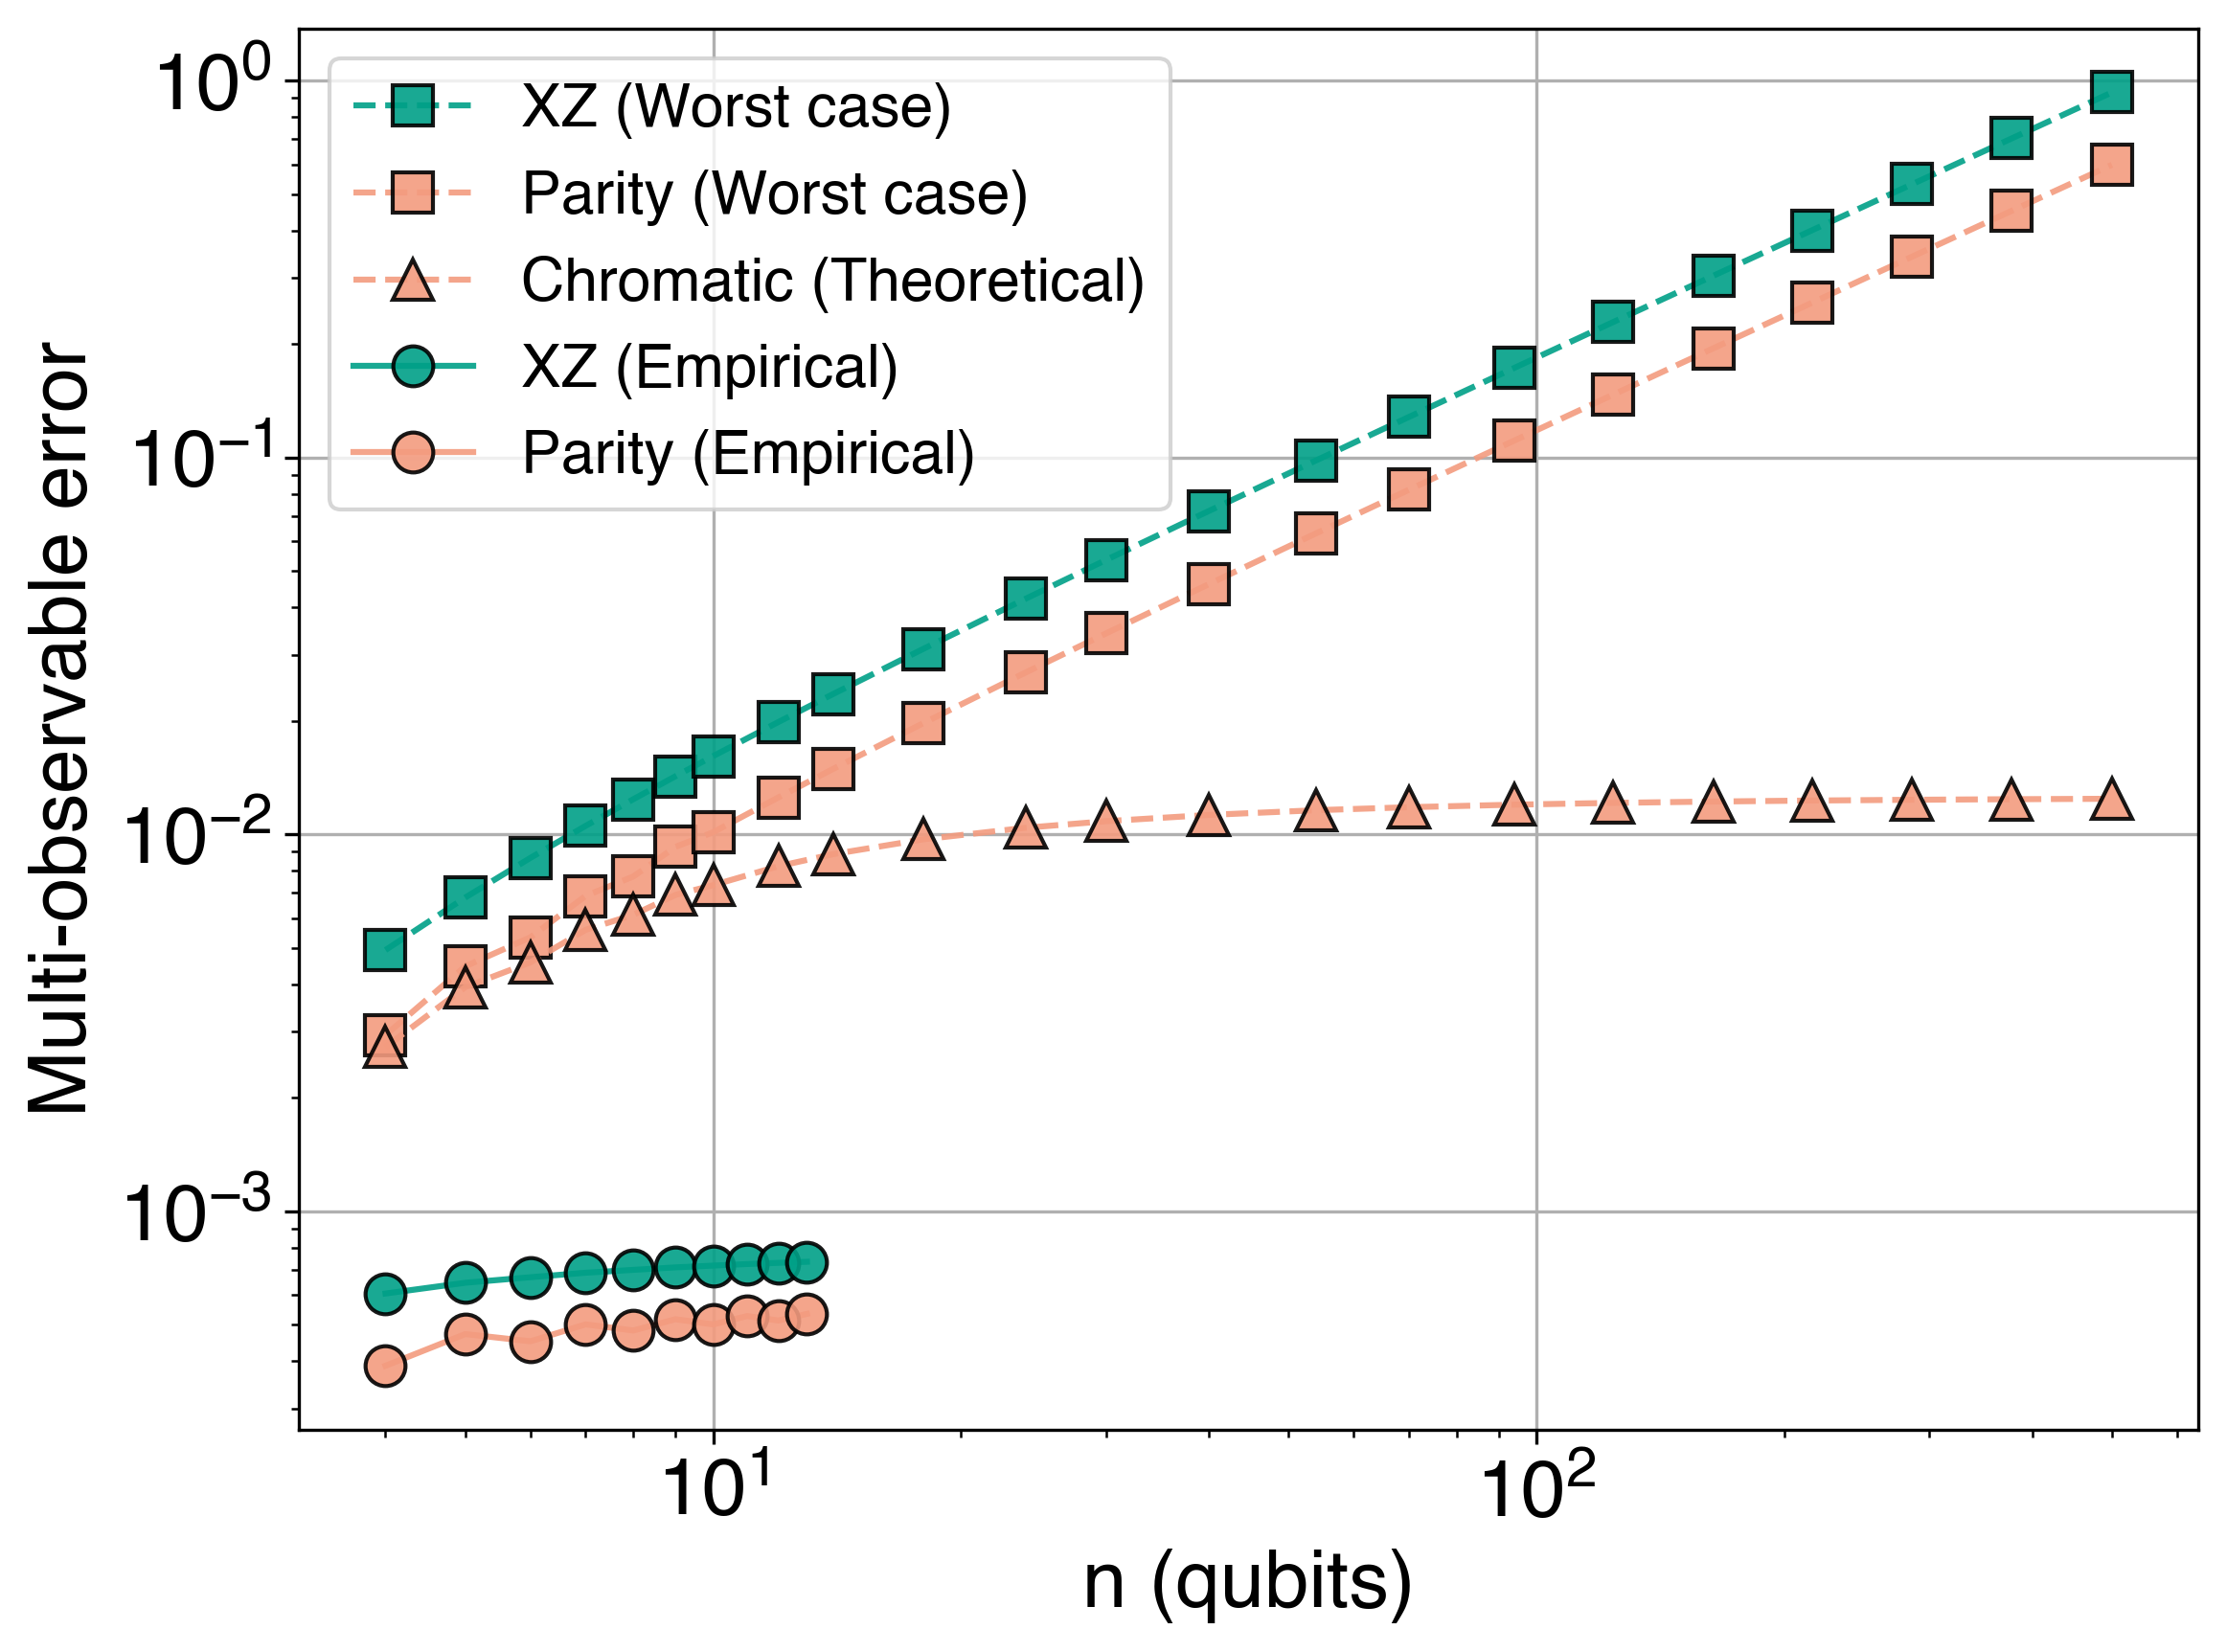

In [ ]:
from spin_ham import TF_Ising_1d
J=1; h=0.2; 
# n = 8; 
t = 0.5
r = 5
# n_list = np.linspace(4, 500, 20, dtype=int)
n_list = [4, 5, 6, 7, 8, 9, 10, 12, 14,  18,  24,  30,  40,  54,  70,  94, 124, 164, 216, 286, 378, 500]
n_list_emp = range(4, 14)
data = {'error_xyz': [], 'error_parity': [], 'error_standard': [], 'error_xyz_emp': [], 'error_parity_emp': []}
print(f"J={J}, h={h}, t={t}, r={r}")
for n in n_list:
    error_xyz = analy_st_loose_bound(r, n, J, h, t, group='xyz')
    error_standard = analy_st_loose_bound(r, n, J, h, t, group='parity')
    error_parity = analy_lc_bound(r, n, J, h, t, ob_type='multi')
    data['error_xyz'].append(error_xyz)
    data['error_standard'].append(error_standard)
    data['error_parity'].append(error_parity)
    # print(f"n={n}, empirical error_xyz={error_xyz}, empirical error_parity={error_parity}")  

for n in n_list_emp:
    tfI = TF_Ising_1d(n, J, h)
    exact_U = expm(-1j * t * tfI.ham.to_matrix())
    appro_U_xyz = standard_trotter([h.to_matrix(True) for h in tfI.ham_xyz], t, r)
    appro_U_parity = standard_trotter([h.to_matrix(True) for h in tfI.ham_parity], t, r)
    magn_op = SparsePauliOp.from_sparse_list([('Z', [i], 1) for i in range(0, n)], n)/n
    # z_op = SparsePauliOp.from_sparse_list([('Z', [0], 1)], n)
    error_xyz = ob_error(magn_op, exact_U, appro_U_xyz)
    error_parity = ob_error(magn_op, exact_U, appro_U_parity)
    data['error_xyz_emp'].append(error_xyz)
    data['error_parity_emp'].append(error_parity)
    print(f"n={n}, empirical error_xyz={error_xyz:.6f}, empirical error_parity={error_parity:.6f}")  

fig, ax = plt.subplots(figsize=(8, 6), layout='tight')
ax.plot(n_list, data['error_xyz'], 's--', color='#00A087FF', label='XZ (Worst case)')
ax.plot(n_list, data['error_standard'], 's--', color='#F39B7FFF', label='Parity (Worst case)')
ax.plot(n_list, data['error_parity'], '^--', color='#F39B7FFF', label='Chromatic (Theoretical)')
ax.plot(n_list_emp, data['error_xyz_emp'], 'o-', color='#00A087FF', label='XZ (Empirical)')
ax.plot(n_list_emp, data['error_parity_emp'], 'o-', color='#F39B7FFF', label='Parity (Empirical)')
ax.loglog()
ax.set_xlabel('n (qubits)')
# ax.set_title(f't={t}, r={r}')
# ax.set_yscale('log')
ax.grid()
ax.set_ylabel('Multi-observable error')
ax.legend() 
fig.savefig(f'../figs/grouping_TFI1d_n={n}_Multi_t={t}.pdf', bbox_inches='tight')

J=1, h=0.2, t=0.5, r=30
n=8, empirical error_xyz=0.000019, empirical error_parity=0.000013
n=8, empirical error_xyz=0.000039, empirical error_parity=0.000027
n=8, empirical error_xyz=0.000062, empirical error_parity=0.000043
n=8, empirical error_xyz=0.000084, empirical error_parity=0.000060
n=8, empirical error_xyz=0.000101, empirical error_parity=0.000075
n=8, empirical error_xyz=0.000109, empirical error_parity=0.000101
n=8, empirical error_xyz=0.000113, empirical error_parity=0.000138
n=8, empirical error_xyz=0.000138, empirical error_parity=0.000184
n=8, empirical error_xyz=0.000207, empirical error_parity=0.000241
n=8, empirical error_xyz=0.000300, empirical error_parity=0.000309
n=8, empirical error_xyz=0.000399, empirical error_parity=0.000389
n=8, empirical error_xyz=0.000489, empirical error_parity=0.000479
n=8, empirical error_xyz=0.000559, empirical error_parity=0.000579
n=8, empirical error_xyz=0.000609, empirical error_parity=0.000688
n=8, empirical error_xyz=0.000661, emp

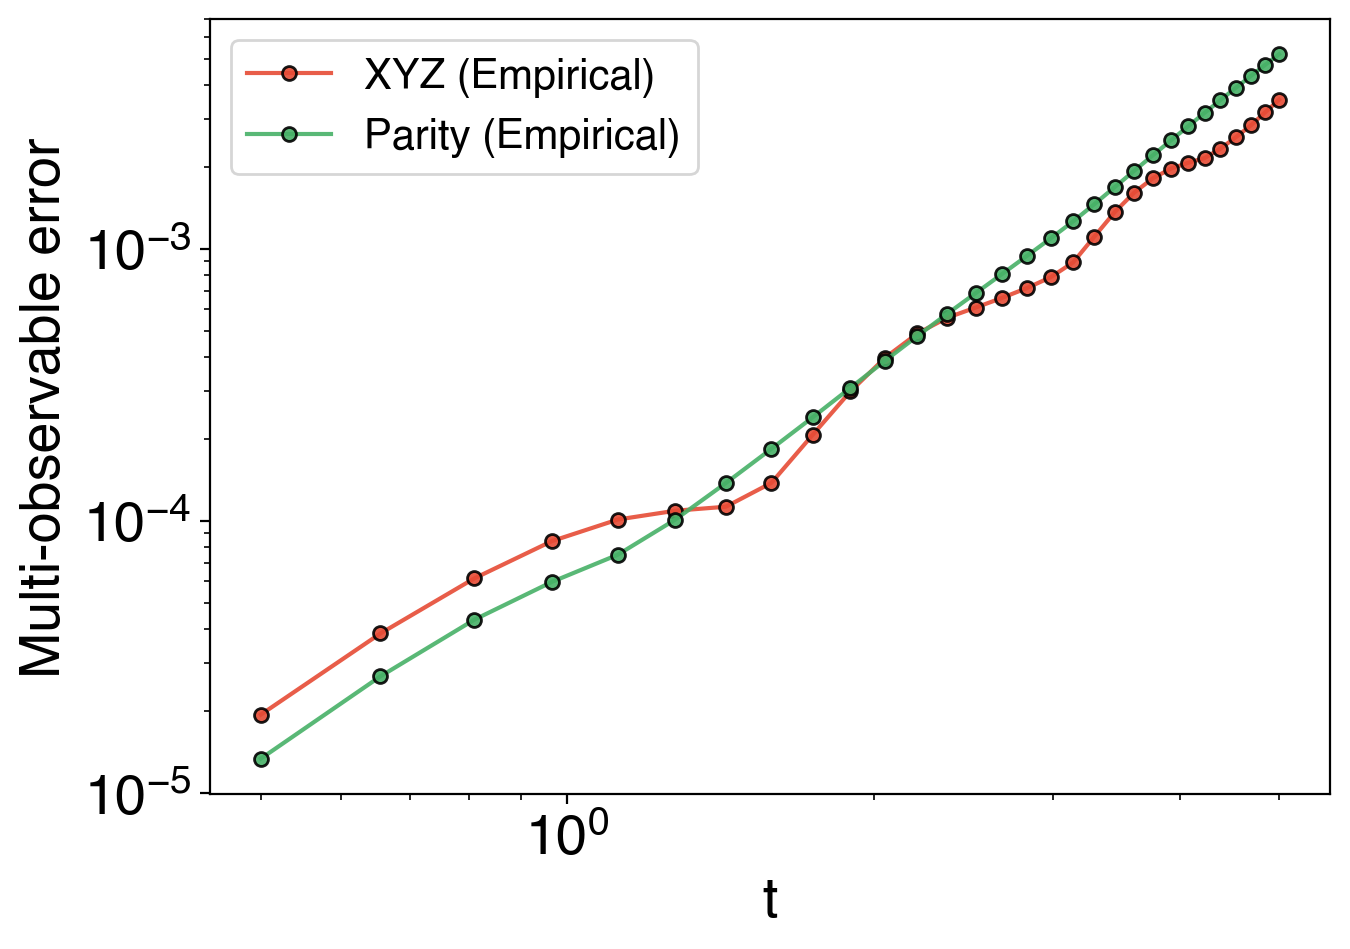

In [ ]:
from spin_ham import TF_Ising_1d
J=1; h=0.2; 
n = 8; 
r = 30
t = 0.5
t_list = np.linspace(0.5, 5, 30)
# n_list = range(4, 20)
# n_list_emp = range(4, 11)
data = {'error_xyz': [], 'error_parity': [], 'error_xyz_emp': [], 'error_parity_emp': []}
print(f"J={J}, h={h}, t={t}, r={r}")

for t in t_list:
    tfI = TF_Ising_1d(n, J, h)
    exact_U = expm(-1j * t * tfI.ham.to_matrix())
    appro_U_xyz = standard_trotter([h.to_matrix(True) for h in tfI.ham_xyz], t, r)
    appro_U_parity = standard_trotter([h.to_matrix(True) for h in tfI.ham_parity], t, r)
    magn_op = SparsePauliOp.from_sparse_list([('Z', [i], 1) for i in range(0, n)], n)/n
    # z_op = SparsePauliOp.from_sparse_list([('Z', [0], 1)], n)
    error_xyz = ob_error(magn_op, exact_U, appro_U_xyz)
    error_parity = ob_error(magn_op, exact_U, appro_U_parity)
    data['error_xyz_emp'].append(error_xyz)
    data['error_parity_emp'].append(error_parity)
    print(f"n={n}, empirical error_xyz={error_xyz:.6f}, empirical error_parity={error_parity:.6f}")  

fig, ax = plt.subplots(figsize=(7, 5), layout='tight')
# ax.plot(n_list, data['error_xyz'], '.--', label='XYZ (Bound)')
# ax.plot(n_list, data['error_parity'], '.--', label='Parity (Bound)')
ax.plot(t_list, data['error_xyz_emp'], '.-', label='XYZ (Empirical)')
ax.plot(t_list, data['error_parity_emp'], '.-', label='Parity (Empirical)')
ax.loglog()
ax.set_xlabel('t')
# ax.set_yscale('log')
ax.set_ylabel('Multi-observable error')
ax.legend() 


In [35]:
tfI.zz_pstr[::-1]
# hnn.z_terms

['IIIZZ', 'IIZZI', 'IZZII', 'ZZIII']

In [4]:
from lightcone import *
from spin_ham import *  
r_start, n, t = 1, 5, 0.5
J, h = 1, 0.2
tfI = transverse_field_ising_1d(n, J, h, [0], t=t, initialize=False)
hnn = Nearest_Neighbour_1d(n, Jx=0, Jy=0, Jz=J, hx=h, hy=0, hz=0, pbc=False, verbose=False)
# print(tfI.H_op)
print(tfI.odd_op)
print(hnn.odd_terms)
exact_U = jax.scipy.linalg.expm(-1j * t * tfI.H_mat.toarray())
appro_U = standard_trotter(tfI.H_parity, t, r_start)
# appro_U = standard_trotter([h.to_matrix(True) for h in hnn.ham_par], t, r_start)
# appro_U = standard_trotter(tfI.H_parity[::-1], t, r_start)
magn_op = SparsePauliOp.from_sparse_list([('Z', [0], 1)], n)
# print('single observable error (jax): ', ob_error(magn_op, exact_U, appro_U))
exact_ob = exact_U.conj().T @ magn_op.to_matrix() @ exact_U 
appro_ob = appro_U.conj().T @ magn_op.to_matrix() @ appro_U
print(f'r={r_start}, single observable error (jax): ', np.linalg.norm(exact_ob - appro_ob, ord=2) )

from trotter import *
ob = SparsePauliOp.from_sparse_list([('Z', [0], 1)], n).to_matrix()
# print(hnn.ham)
print(tfI.even_op)
print(hnn.even_terms)
r = 1
h_list = [h.to_matrix() for h in hnn.ham_par[::-1]]
exact_U = np.matrix(jax.scipy.linalg.expm(-1j * t * sum([h for h in h_list])))
list_U = [jax.scipy.linalg.expm(-1j * (t / (2*r)) * h) for h in h_list]
appro_U_dt_forward = np.matmul(list_U[0], list_U[1])
appro_U_dt_reverse = np.matmul(list_U[1], list_U[0])
appro_U = np.matrix(np.linalg.matrix_power(np.matmul(appro_U_dt_reverse, appro_U_dt_forward), r))
exact_ob = np.matmul(exact_U.H, np.matmul(ob, exact_U))
appro_ob = np.matmul(appro_U.H, np.matmul(ob, appro_U))
exact_ob_s = exact_U.conj().T @ ob @ exact_U 
appro_ob_s = appro_U.conj().T @ ob @ appro_U
np.linalg.norm(exact_ob_s - appro_ob_s, ord=2)  

SparsePauliOp(['IIZZI', 'ZZIII', 'IIIXI', 'IXIII'],
              coeffs=[1. +0.j, 1. +0.j, 0.2+0.j, 0.2+0.j])
SparsePauliOp(['IIZZI', 'ZZIII', 'IIIXI', 'IXIII'],
              coeffs=[1. +0.j, 1. +0.j, 0.2+0.j, 0.2+0.j])
r=1, single observable error (jax):  0.0020430607
SparsePauliOp(['IIIZZ', 'IZZII', 'IIIIX', 'IIXII', 'XIIII'],
              coeffs=[1. +0.j, 1. +0.j, 0.2+0.j, 0.2+0.j, 0.2+0.j])
SparsePauliOp(['IIIZZ', 'IZZII', 'IIIIX', 'IIXII', 'XIIII'],
              coeffs=[1. +0.j, 1. +0.j, 0.2+0.j, 0.2+0.j, 0.2+0.j])


0.002043025327695573

### Main

In [4]:
# r_lc_found_list_s
from lightcone import * 
r, n, J, h, t = 1, 8, 1, 0.2, 1
analy_lc_bound(r, n, J, h, t, ob_type='single', verbose=True)
analytic_loose_commutator_bound(2, J, h, t/r, verbose=True) 

single
c1 (analy)=8.0, c2=3.2
c1 (analy)=0.16000000000000003, c2=0.9600000000000001
c1 (analy)=0.16000000000000003, c2=0.9600000000000001


0.05333333333333334

--------------------------n=4----------------------------
=========pf_type=standard, ob_type=multi=========
r=10; error=0.000733; exp_count=160
r=5; error=0.002933; exp_count=80
r=3; error=0.008148; exp_count=48
r=4; error=0.004583; exp_count=64
-------- binary search end --------
=========pf_type=lightcone, ob_type=multi=========
r=10; error=0.000708; exp_count=160
r=5; error=0.002727; exp_count=80
r=3; error=0.007191; exp_count=48
r=4; error=0.004180; exp_count=64
-------- binary search end --------
standard: error=0.004583; exp_count=32
lightcone: error=0.004180; exp_count=51
=========pf_type=lightcone, ob_type=single=========
r=10; error=0.000673; exp_count=147
r=5; error=0.002453; exp_count=67
r=3; error=0.005926; exp_count=35
r=4; error=0.003646; exp_count=51
-------- binary search end --------
lightcone: error=0.003646; exp_count=51
--------------------------n=5----------------------------
=========pf_type=standard, ob_type=multi=========
r=13; error=0.000661; exp_count=260
r=7;

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


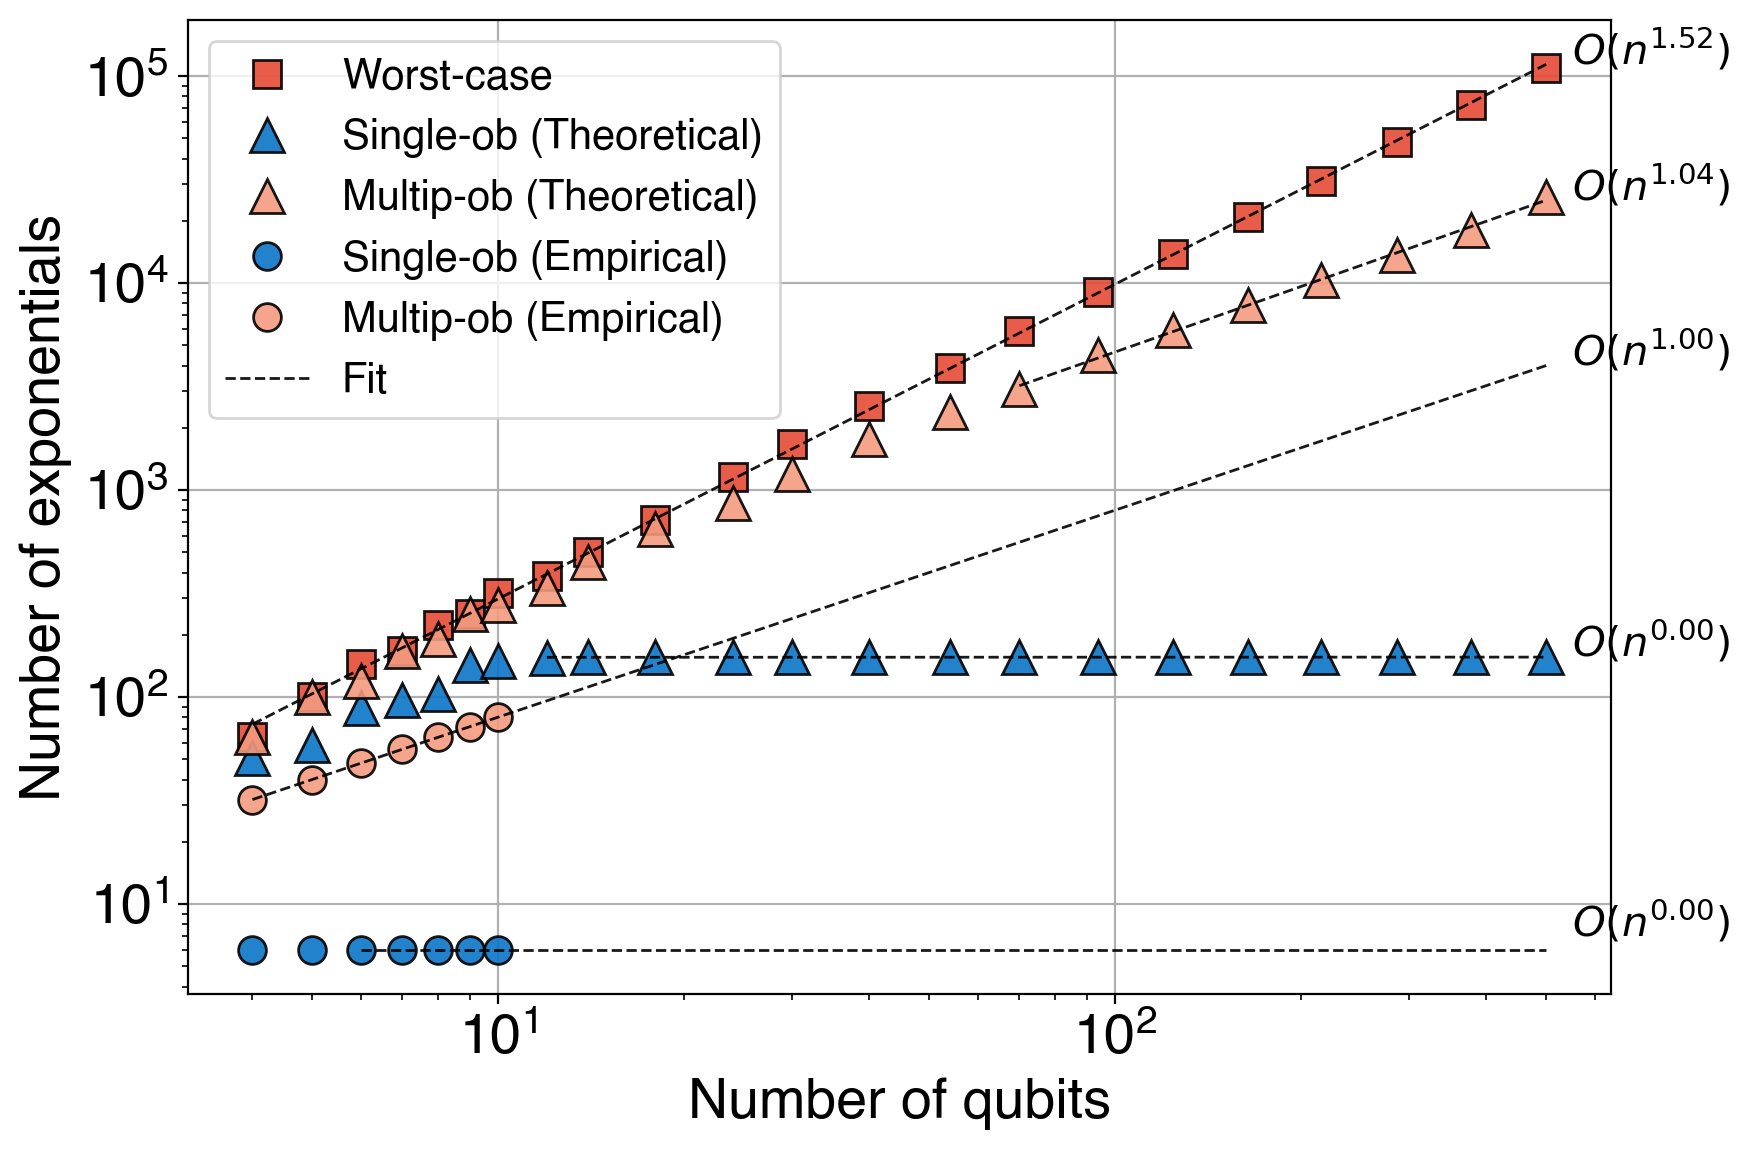

In [1]:
from utils import *
from lightcone import *

from matplotlib.ticker import ScalarFormatter
formatter = ScalarFormatter(useMathText=False)
formatter.set_scientific(False)
# n_list = [7, 8, 9, 10]
# n_list = range(4, 200, 5)
# n_list = np.array(sorted(list(set(np.logspace(0.65, 2.5, 30, dtype=int)))))
n_list = [4, 5, 6, 7, 8, 9, 10, 12, 14,  18,  24,  30,  40,  54,  70,  94, 124, 164, 216, 286, 378, 500]
# n_list = [4, 5, 6, 7, 8, 9, 10, 12,  16,  20,  26,  34,  43,  56,  71,  92, 117, 150, 193, 247, 316]
# n_list = np.array(sorted(list(set(np.logspace(0.65, 3.0, 40, dtype=int)))))
# n_list = np.logspace(0.6, 2.3, 40, dtype=int)    
# n_list = range(4, 150, 3)
n_list_emp = range(4, 11, 1)
# st_r_bound_n, st_cost_bound_n, lc_r_bound_n, lc_cost_bound_n, em_r_bound_n, em_cost_bound_n = [], [], [], [], [], []
ob_index = [0]
# t = 1.0
t = 0.5
J=1; h=0.2
# J=1/2; h=1/2
ob_type = 'multi'
epsilon=0.005; search_precision=0.02
r_st_found_list, r_lc_found_list, cost_st_found_list, cost_lc_found_list, r_em_found_list, cost_em_found_list = [], [], [], [], [], []
r_lc_found_list_s, cost_lc_found_list_s, r_em_found_list_s, cost_em_found_list_s = [], [], [], []
for n in n_list:
    print(f'--------------------------n={n}----------------------------')
    # ob, ob_dict = local_ob(ob_index, n)
    # ising1d_n_bd = transverse_field_ising_1d(n, J, h, ob_index, t=t, initialize=True, verbose=verbose)
    # print(ising1d_n_bd.all_terms)
    # print(2 * tight_bound([h.to_matrix() for h in ising1d_n_bd.all_terms], 2, t, 1))
    # print('========== STANDARD Bound ==========')
    r_list_st, error_list_st, exp_count_list_st, r_found_st, r_err_dict_st = bin_search_r(n, J, h, t, epsilon, search_precision, pf_type='standard', ob_type='multi', verbose=True)
    r_list_lc, error_list_lc, exp_count_list_lc, r_found_lc, r_err_dict_lc = bin_search_r(n, J, h, t, epsilon, search_precision, pf_type='lightcone', ob_type='multi', verbose=True)
    print(f'standard: error={r_err_dict_st[r_found_st]:.6f}; exp_count={ 2 * n * r_found_st}')
    print(f'lightcone: error={r_err_dict_lc[r_found_lc]:.6f}; exp_count={exp_count_LC(r_found_lc, n, 2*n)}')
    r_st_found_list.append(r_found_st)
    r_lc_found_list.append(r_found_lc)
    cost_st_found_list.append(2 * (2*n) * r_found_st)
    cost_lc_found_list.append(2 * (2*n) * r_found_lc)

    # print('========== LIGHTCONE Bound ==========')
    r_list_lc_s, error_list_lc_s, exp_count_list_lc_s, r_found_lc_s, r_err_dict_lc_s = bin_search_r(n, J, h, t, epsilon, search_precision, pf_type='lightcone', verbose=True)
    print(f'lightcone: error={r_err_dict_lc_s[r_found_lc_s]:.6f}; exp_count={exp_count_LC(r_found_lc_s, n, 2*n)}')
    r_lc_found_list_s.append(r_found_lc_s)
    cost_lc_found_list_s.append(exp_count_LC(r_found_lc_s, n, 2*n))
    # cost_lc_found_list.append(exp_count_LC(r_found_lc, n, 2*n))

    # _, _, _, r_bound = binary_search_r(ising1d_n, ob, t, epsilon, search_precision, type='bound', verbose=True)
    # st_r_bound_n.append(r_bound)
    # st_cost_bound_n.append(r_bound*2*ising1d_n.n_terms)
for n in n_list_emp:
    print(f'========== EMPIRICAL n={n}==========')
    r_list_em, error_list_em, exp_count_list_em, r_found_em, r_err_dict_em = bin_search_r(n, J, h, t, epsilon, search_precision, pf_type='empirical', ob_type='multi', verbose=True)
    print(f'empirical: error={r_err_dict_em[r_found_em]:.6f}; exp_count={ 2 * n * r_found_em}')
    r_em_found_list.append(r_found_em)
    cost_em_found_list.append(2 * (2*n) * r_found_em)

    r_list_em_s, error_list_em_s, exp_count_list_em_s, r_found_em_s, r_err_dict_em_s = bin_search_r(n, J, h, t, epsilon, search_precision, pf_type='empirical', ob_type='single', verbose=True)
    # print(f'empirical: error={r_err_dict_em[r_found_em]:.6f}; exp_count={ 2 * n * r_found_em}')
    # r_em_found_list.append(r_found_em)
    # cost_em_found_list.append(2 * (2*n) * r_found_em)
    cost_em_found_list_s.append(exp_count_LC(r_found_em_s, n, 2*n))
    # cost_em_found_list_s.append(exp_count_LC(r_found_em, n, 2*n))
    # cost_em_found_list_s.append(exp_count_list_em_s[-1])

fig, ax2 = plt.subplots(figsize=(9, 6), layout='tight')
ob_string = 'XIII'
ax2.plot(n_list, cost_st_found_list, 's', color='#E64B35FF', label=r'Worst-case', markersize=10)
# ax2.plot(n_list, cost_st_found_list, 's', label=r'Worst-case (Ref \textcolor{blue}{[13]})', markersize=10)
ax2.plot(n_list, cost_lc_found_list_s, '^', color='#0A75C7', label='Single-ob (Theoretical)', markersize=12)
ax2.plot(n_list, cost_lc_found_list, '^', color='#F39B7FFF', label='Multip-ob (Theoretical)', markersize=12)
ax2.plot(n_list_emp, cost_em_found_list_s, 'o', color='#0A75C7', label='Single-ob (Empirical)')
ax2.plot(n_list_emp, cost_em_found_list, 'o', color='#F39B7FFF', label='Multip-ob (Empirical)')
# ax2.plot(n_list, r_lc_found_list, '-*', label='Lightcone (bound)', markeredgecolor='k')
# Add labels and a legend
ax2.set_xlabel('Number of qubits')
ax2.set_ylabel('Number of exponentials')
# ax2.set_title(fr'ob=$\sum Z_j/n$, TFI (fix t={t}, $\epsilon$={epsilon}) PF2')  

ax2.xaxis.set_major_formatter(formatter)
# ax2.set_yscale('log')
# ax2.set_xscale('log')

y_pred_st, a_st, b_st = linear_loglog_fit(n_list, cost_st_found_list)
ax2.plot(n_list, y_pred_st, 'k--', linewidth=1)
ax2.annotate(r'$O(n^{%s})$' % str(a_st)[:4], xy=(n_list[-1], np.real(y_pred_st)[-1]), xytext=(n_list[-1]*1.1, np.real(y_pred_st)[-1]+1))

perc= 3/2.0
# perc= 3/2.2
# perc= 3/2.5
print(n_list[int(len(n_list)/perc)])
y_pred_lc, a_lc, b_lc = linear_loglog_fit(n_list[int(len(n_list)/perc):], cost_lc_found_list[int(len(n_list)/perc):])
ax2.plot(n_list[int(len(n_list)/perc):], y_pred_lc, 'k--', label='Fit', linewidth=1)
ax2.annotate(r'$O(n^{%s})$' % str(a_lc)[:4], xy=(n_list[-1], np.real(y_pred_lc)[-1]), xytext=(n_list[-1]*1.1, np.real(y_pred_lc)[-1]+1))

# multip-ob empirical
y_pred_em, a_em, b_em = linear_loglog_fit(n_list_emp, cost_em_found_list)
print(f'a_em: {a_em}; b_em: {b_em}')
text_a_em = "{:.2f}".format(round(abs(a_em), 4))
y_pred_em = [exp(cost) for cost in a_em*np.array([log(n) for n in n_list])+b_em]
ax2.plot(n_list, y_pred_em, 'k--', linewidth=1)
# ax2.plot(n_list_emp, y_pred_em, 'k--', linewidth=1)
ax2.annotate(r'$O(n^{%s})$' % text_a_em, xy=(n_list_emp[-1], np.real(y_pred_em)[-1]), xytext=(n_list[-1]*1.1, np.real(y_pred_em)[-1]+1))

# single-ob empirical
y_pred_em, a_em, b_em = linear_loglog_fit(n_list_emp[3:], cost_em_found_list_s[3:])
print(f'a_em: {a_em}; b_em: {b_em}')
text_a_em = "{:.2f}".format(round(abs(a_em), 4))
y_pred_em = [exp(cost) for cost in a_em*np.array([log(n) for n in n_list])+b_em]
ax2.plot(n_list[2:], y_pred_em[2:], 'k--', linewidth=1)
# ax2.plot(n_list_emp, y_pred_em, 'k--', linewidth=1)
ax2.annotate(r'$O(n^{%s})$' % text_a_em, xy=(n_list_emp[-1], np.real(y_pred_em)[-1]), xytext=(n_list[-1]*1.1, np.real(y_pred_em)[-1]+1))
# ax2.annotate(r'$O(n^{%s})$' % str(round(abs(a_em), 4))[:4], xy=(n_list_emp[-1], np.real(y_pred_em)[-1]), xytext=(n_list[-1]*1.1, np.real(y_pred_em)[-1]+1))

# single-ob bound
perc= 3
y_pred_lc, a_lc, b_lc = linear_loglog_fit(n_list[int(len(n_list)/perc):], cost_lc_found_list_s[int(len(n_list)/perc):])
text_a_lc = "{:.2f}".format(round(abs(a_lc), 4))
ax2.plot(n_list[int(len(n_list)/perc):], y_pred_lc, 'k--', linewidth=1)
# ax2.annotate(r'$O(n^{%s})$' % text_a_lc, xy=(n_list[-1], np.real(y_pred_lc)[-1]), xytext=(n_list[-1]*1.1, np.real(y_pred_lc)[-1]+1))
ax2.annotate(r'$O(n^{%s})$' % text_a_lc, xy=(n_list[-1], np.real(y_pred_lc)[-1]), xytext=(n_list[-1]*1.1, np.real(y_pred_lc)[-1]+1))
# ax2.xaxis.set_major_formatter(ScalarFormatter())
ax2.loglog()

# ax2.set_xticks(range(int(min(n_list)), int(max(n_list)) + 1))
# plt.title('Two Lines with Intersection Point')
ax2.legend()
ax2.grid()
# fig.savefig(f'../figs/lightcone_TFI1d_n={n}_eps={epsilon}_Bound_costVSn_multiOB_t={t}.pdf')
# fig.savefig(f'./figs/lightcone_TFI1d_n={n}_eps={epsilon}_SingleMulti_t={t}.pdf', bbox_inches='tight')

In [ ]:
analy_lc_bound(3, 500, J, h, t)

NameError: name 'J' is not defined

### Bounds (tight, loose)

In [ ]:
from lattice_hamiltonians import heisenberg_1d
n = 4; is_pbc = True; J = 1; h = 1
ising_bd = transverse_field_ising_1d(n, J, h, [1], 4, pbc=is_pbc, verbose=False)
# ising_bd = heisenberg_1d(2, 1, 1, 1, 2, verbose=False)
ising_bd.H_parity
h_list = ising_bd.all_terms

print('all terms: ', h_list)
commutator_bound(h_list, 2, 1, 1, type='tight')
commutator_bound(h_list, 2, 1, 1,type='loose')
tight_err = tight_bound([h.to_matrix() for h in h_list], 2, 1, 1)
print('tight_err: ', tight_err)
print('tight bound (parity): ', tight_bound(ising_bd.H_parity, 2, 1, 1))
print('analytic loose error:', analytic_loose_commutator_bound(n, J, h, 1, pbc=is_pbc))
print('tight bound (parity) first: ', tight_bound(ising_bd.H_parity, 1, 1, 1))
print('tight bound (all) first: ', tight_bound([h.to_matrix() for h in h_list], 1, 1, 1))

---------------------initialization start---------------------
----expm: exact U evaluated (t=4)----
single local observabel: {'X': [1]}
observable:  SparsePauliOp(['XIII'],
              coeffs=[1.+0.j])
evaluation: standard error bound
c1 (analy)=56, c2=24
evaluation: lightcone decompose
evalution: lightcone error bound
c1 (analy)=36, c2=16
c1 (analy)=56, c2=24
[['IXII', 'IZZI', 'ZZII', 'IIIX'], ['IIXI', 'IIZZ', 'XIII', 'ZIIZ']]
---------------------initialization done---------------------
all terms:  [SparsePauliOp(['ZZII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IZZI'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIZZ'],
              coeffs=[1.+0.j]), SparsePauliOp(['ZIIZ'],
              coeffs=[1.+0.j]), SparsePauliOp(['XIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IXII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIXI'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIX'],
              coeffs=[1.+0.j])]
c1 (tight)=69.20225231898308, c2=32.0
tigh

In [ ]:
# print(h_list)
# norm(commutator(ising_bd.H_parity[0], ising_bd.H_parity[1]))
print(commutator(ising_bd.even_op, ising_bd.odd_op).simplify())
print(norm(commutator(ising_bd.even_op, ising_bd.odd_op).simplify()))
norm(SparsePauliOp(['ZYII', 'IIZY', 'YIIZ', 'IZYI'], coeffs=[4j, 4j, -4j, -4j]))/2

SparsePauliOp(['ZYII', 'IIZY', 'YIIZ', 'IZYI'],
              coeffs=[0.+4.j, 0.+4.j, 0.-4.j, 0.-4.j])
11.313708498984761


5.656854249492381

In [ ]:
lightcone_bound_simplified(ising1d, 9, verbose=True)
lightcone_bound_simplified(ising1d, ising1d.r_saturate, verbose=True)

bound list:  [0.000177 0.000395 0.000618 0.000841]
bound list:  [0.001031 0.002305 0.003602 0.004906]


0.016750620270343665